# Imports

In [530]:
from collections import Counter

In [531]:
from sklearn import datasets
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.decomposition import PCA

In [532]:
import numpy as np

In [533]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-paper")
plt.rcParams["image.cmap"] = "Dark2"

In [534]:
import pandas as pd

# Setup Data

In [535]:
n_obs = 2048
n_feats = 2

In [536]:
params_linear = dict(
    n_samples=n_obs, n_features=n_feats,
    centers=[[-2, -2], [2, 2]],
    cluster_std=1.5
)

In [537]:
params_blobs = dict(
    n_samples=n_obs, n_features=n_feats,
    centers=[
        [-2, -2], [2, 2],
        [-2, 2], [2, -2],
    ],
    cluster_std=1.2
)

In [538]:
params_moons = dict(
    n_samples=n_obs, noise=0.2,
)

## Linear
[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html)

In [539]:
def get_linear():
    data, target = datasets.make_blobs(**params_linear)
    target = (target == 1) * 2 - 1
    return data, target

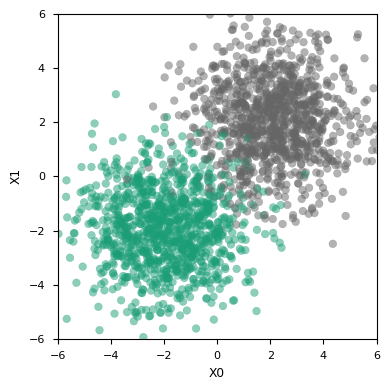

In [540]:
data, target = get_linear()

plt.figure(figsize=(4, 4))
plt.scatter(data[:, 0], data[:, 1], c=target, alpha=.5)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel("X0")
plt.ylabel("X1")
plt.tight_layout()
plt.show()
plt.close()

## Blobs
[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html)

In [541]:
def get_blobs():
    data, target = datasets.make_blobs(**params_blobs)
    target = np.isin(target, [0, 1]) * 2 - 1
    return data, target

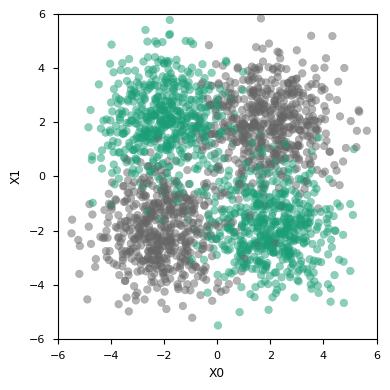

In [542]:
data, target = get_blobs()

plt.figure(figsize=(4, 4))
plt.scatter(data[:, 0], data[:, 1], c=target, alpha=.5)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel("X0")
plt.ylabel("X1")
plt.tight_layout()
plt.show()
plt.close()

## Moons
[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html)

In [543]:
def get_moons():
    data, target = datasets.make_moons(**params_moons)

    target = (target == 1) * 2 - 1
    data = data - [data[:, 0].mean(), data[:, 1].mean()]
    return data, target

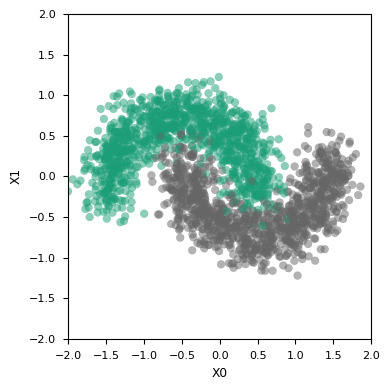

In [544]:
data, target = get_moons()

plt.figure(figsize=(4, 4))
plt.scatter(data[:, 0], data[:, 1], c=target, alpha=.5)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("X0")
plt.ylabel("X1")
plt.tight_layout()
plt.show()
plt.close()

# Modeling

In [545]:
neurons = 100

## Step by step

### Training

In [546]:
X_train, X_test, y_train, y_test = train_test_split(*get_blobs(), test_size=.3)

* Generate random hidden layer weights

In [547]:
w_input = np.random.uniform(size=(X_train.shape[1] + 1, neurons))
w_input.shape

(3, 100)

* Calculate hidden layer input

In [548]:
hidden_input = (
    np.hstack([np.ones(shape=(X_train.shape[0], 1)), X_train])
    @ w_input
)
hidden_input.shape

(1433, 100)

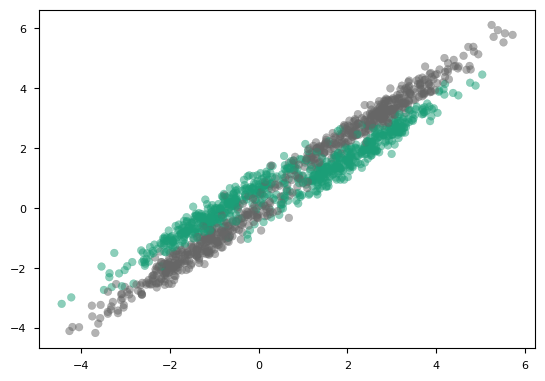

In [549]:
plt.scatter(hidden_input[:, 0], hidden_input[:, 1], c=y_train, alpha=.5)

* Calculate hidden layer output

In [550]:
hidden_output = np.tanh(hidden_input)
hidden_output = np.hstack([
    np.ones(shape=(X_train.shape[0], 1)),
    hidden_output
])
hidden_output.shape

(1433, 101)

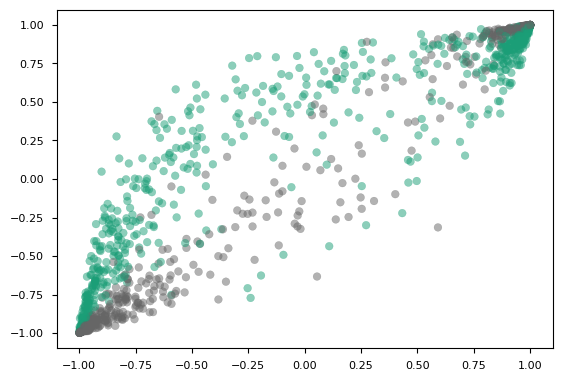

In [551]:
plt.scatter(hidden_output[:, 1], hidden_output[:, 2], c=y_train, alpha=.5)

* Calculate PCA weights to set up second hidden layer

In [552]:
means = hidden_output.mean(axis=0)
zero_mean = hidden_output - means
cov = np.cov(zero_mean.T)
eig_val, eig_vec = np.linalg.eig(np.round(cov, 5))

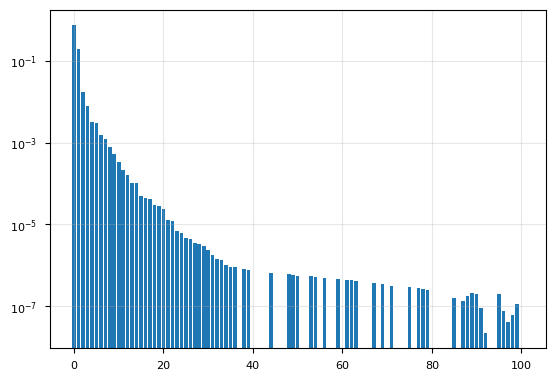

In [553]:
explained_var = eig_val / np.sum(eig_val)
plt.bar(range(explained_var.shape[0]), explained_var)
plt.yscale("log")
plt.grid(alpha=.3)

In [554]:
pca_input = np.dot(zero_mean, eig_vec)
pca_input.shape

(1433, 101)

In [555]:
pca_output = np.tanh(pca_input)
pca_output = np.hstack([
    np.ones(shape=(X_train.shape[0], 1)),
    pca_output
])
pca_output.shape

(1433, 102)

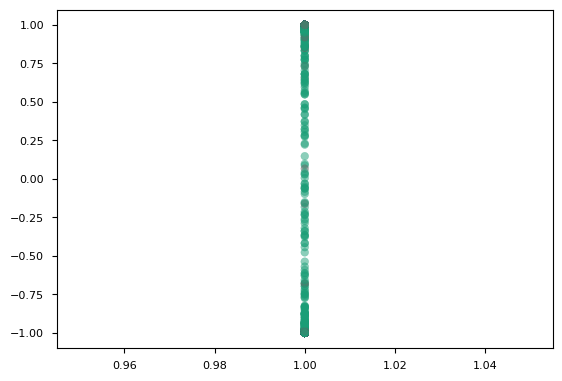

In [556]:
plt.scatter(pca_output[:, 0], pca_output[:, 1], c=y_train, alpha=.5)

* Calculate output layer weights

In [557]:
w_output = np.linalg.pinv(pca_output) @ y_train
w_output.shape

(102,)

* Calculate and evaluate training predictions

In [558]:
output_input = pca_output @ w_output
preds = (output_input.reshape(-1, 1) > 0).reshape(-1) * 2 - 1
preds.shape

(1433,)

In [559]:
print(classification_report(
    y_true=y_train, y_pred=preds,
    zero_division=0,
))

              precision    recall  f1-score   support

          -1       0.91      0.93      0.92       733
           1       0.93      0.90      0.92       700

    accuracy                           0.92      1433
   macro avg       0.92      0.92      0.92      1433
weighted avg       0.92      0.92      0.92      1433



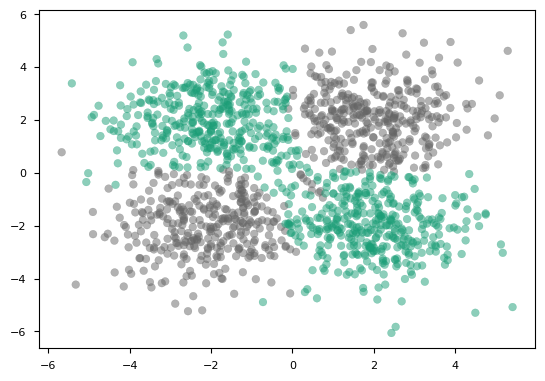

In [560]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=preds, alpha=.5)

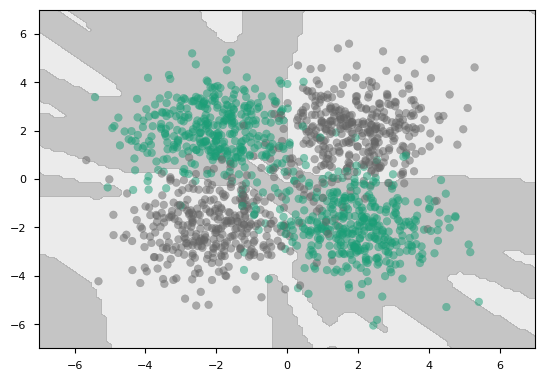

In [561]:
steps = 100
value = np.ceil(np.max([X_train.max(), np.abs(X_train.min())]))
grid = np.linspace(-1 * value, value, num = steps)
grid_data = np.array([[x0, x1] for x0 in grid for x1 in grid])

hidden_input = (
    np.hstack([np.ones(shape=(grid_data.shape[0], 1)), grid_data])
    @ w_input
)
hidden_output = np.tanh(hidden_input)
hidden_output = np.hstack([
    np.ones(shape=(grid_data.shape[0], 1)),
    hidden_output
])
pca_input = np.dot(hidden_output - means, eig_vec)
pca_output = np.tanh(pca_input)
pca_output = np.hstack([
    np.ones(shape=(grid_data.shape[0], 1)),
    pca_output
])
output_input = pca_output @ w_output
preds = (output_input.reshape(-1, 1) > 0).reshape(-1) * 2 - 1

plt.contourf(
    grid, grid,
    (preds * -1 > 0).reshape(steps, steps),
    levels=1, alpha=.3, cmap="binary"
)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, alpha=.5)

### Testing

* Calculate hidden layer input

In [562]:
hidden_input = (
    np.hstack([np.ones(shape=(X_test.shape[0], 1)), X_test])
    @ w_input
)
hidden_input.shape

(615, 100)

* Calculate hidden layer output

In [563]:
hidden_output = np.tanh(hidden_input)
hidden_output = np.hstack([
    np.ones(shape=(X_test.shape[0], 1)),
    hidden_output
])
hidden_output.shape

(615, 101)

* Calculate PCA output

In [564]:
pca_input = np.dot(hidden_output - means, eig_vec)
pca_output = np.tanh(pca_input)
pca_output = np.hstack([
    np.ones(shape=(X_test.shape[0], 1)),
    pca_output
])

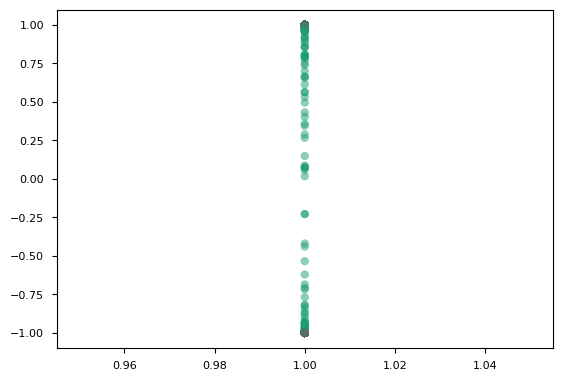

In [565]:
plt.scatter(pca_output[:, 0], pca_output[:, 1], c=y_test, alpha=.5)

* Calculate output layer input values

In [566]:
output_input = pca_output @ w_output
output_input.shape

(615,)

* Output layer activation function is linear

In [567]:
preds = (output_input.reshape(-1, 1) > 0).reshape(-1) * 2 - 1
preds.shape

(615,)

### Evaluate

In [568]:
print(classification_report(
    y_true=y_test, y_pred=preds,
    zero_division=0,
))

              precision    recall  f1-score   support

          -1       0.91      0.90      0.90       291
           1       0.91      0.92      0.91       324

    accuracy                           0.91       615
   macro avg       0.91      0.91      0.91       615
weighted avg       0.91      0.91      0.91       615



## Setup sklearn model class

### Model class definition

In [569]:
class ELMClassifier(ClassifierMixin, BaseEstimator):
    def __init__(self, neurons: int):
        self.neurons = neurons

    def fit(self, X, y):
        # generate random hidden layer weights [store input weights]
        self.w_input_ = np.random.uniform(size=(X.shape[1] + 1, self.neurons))

        # calculate hidden layer input
        hidden_input = (
            np.hstack([np.ones(shape=(X.shape[0], 1)), X])
            @ self.w_input_
        )

        # calculate hidden layer output
        hidden_output = np.tanh(hidden_input)
        hidden_output = np.hstack([
            np.ones(shape=(X.shape[0], 1)),
            hidden_output
        ])

        # calculate hidden pca layer input [store training data mean and eigen vectors]
        self.means_ = hidden_output.mean(axis=0)
        cov = np.cov((hidden_output - self.means_).T)
        eig_val, self.eig_vec_ = np.linalg.eig(np.round(cov, 5))

        # calculate hidden pca layer output
        pca_input = np.dot(hidden_output - self.means_, self.eig_vec_)
        pca_output = np.tanh(pca_input)
        pca_output = np.hstack([
            np.ones(shape=(X.shape[0], 1)),
            pca_output
        ])

        # calculate output layer weights [store output weights]
        self.w_output_ = np.linalg.pinv(pca_output) @ y

        return self

    def predict(self, X):
        # calculate hidden layer input [use input weights]
        hidden_input = (
            np.hstack([np.ones(shape=(X.shape[0], 1)), X])
            @ self.w_input_
        )

        # calculate hidden layer output
        hidden_output = np.tanh(hidden_input)
        hidden_output = np.hstack([
            np.ones(shape=(X.shape[0], 1)),
            hidden_output
        ])

        # calculate pca layer output
        pca_input = np.dot(hidden_output - self.means_, self.eig_vec_)
        pca_output = np.tanh(pca_input)
        pca_output = np.hstack([
            np.ones(shape=(X.shape[0], 1)),
            pca_output
        ])

        # calculate output layer input values
        output_input = pca_output @ self.w_output_

        # output layer activateion function is linear
        return output_input.reshape(-1, 1)

### Evaluate with linear

In [570]:
X_train, X_test, y_train, y_test = train_test_split(*get_linear(), test_size=.3)

In [571]:
model = ELMClassifier(neurons=2)
model.fit(X_train, y_train)
preds = (model.predict(X_test).reshape(-1, 1) > 0).reshape(-1) * 2 - 1
print(classification_report(
    y_true=y_test, y_pred=preds,
    zero_division=0,
))

              precision    recall  f1-score   support

          -1       0.98      0.94      0.96       317
           1       0.94      0.98      0.96       298

    accuracy                           0.96       615
   macro avg       0.96      0.96      0.96       615
weighted avg       0.96      0.96      0.96       615



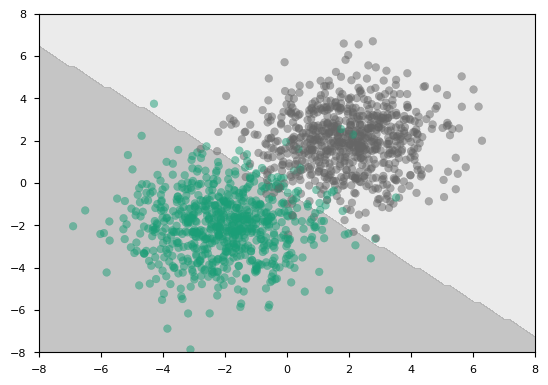

In [572]:
steps = 100
value = np.ceil(np.max([X_train.max(), np.abs(X_train.min())]))
grid = np.linspace(-1 * value, value, num = steps)
grid_data = np.array([[x0, x1] for x0 in grid for x1 in grid])

preds = (model.predict(grid_data).reshape(-1, 1) > 0).reshape(-1) * 2 - 1

plt.contourf(
    grid, grid,
    (preds * -1 > 0).reshape(steps, steps),
    levels=1, alpha=.3, cmap="binary"
)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, alpha=.5)

In [573]:
res = list()
for i in range(2, 256, 10):
    model = ELMClassifier(neurons=i)
    model.fit(X_train, y_train)

    res.append({
        'neurons': i,
        'accuracy_train': np.mean(
            (model.predict(X_train) > 0).reshape(-1)
            == (y_train > 0).reshape(-1)
        ),
        'accuracy_test': np.mean(
            (model.predict(X_test) > 0).reshape(-1)
            == (y_test > 0).reshape(-1)
        ),
    })
df_res = pd.json_normalize(res)

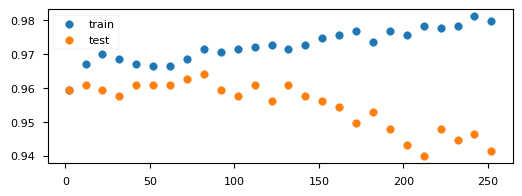

In [574]:
plt.figure(figsize=(6, 2))
plt.scatter(df_res['neurons'], df_res['accuracy_train'], label='train')
plt.scatter(df_res['neurons'], df_res['accuracy_test'], label='test')
plt.legend()
plt.show()
plt.close()

### Evaluate with blobs

In [575]:
X_train, X_test, y_train, y_test = train_test_split(*get_blobs(), test_size=.3)

In [576]:
model = ELMClassifier(neurons=64)
model.fit(X_train, y_train)
preds = (model.predict(X_test).reshape(-1, 1) > 0).reshape(-1) * 2 - 1
print(classification_report(
    y_true=y_test, y_pred=preds,
    zero_division=0,
))

              precision    recall  f1-score   support

          -1       0.90      0.90      0.90       293
           1       0.91      0.90      0.91       322

    accuracy                           0.90       615
   macro avg       0.90      0.90      0.90       615
weighted avg       0.90      0.90      0.90       615



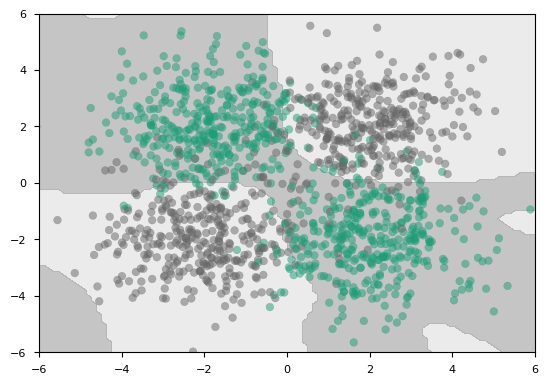

In [577]:
steps = 100
value = np.ceil(np.max([X_train.max(), np.abs(X_train.min())]))
grid = np.linspace(-1 * value, value, num = steps)
grid_data = np.array([[x0, x1] for x0 in grid for x1 in grid])

preds = (model.predict(grid_data).reshape(-1, 1) > 0).reshape(-1) * 2 - 1

plt.contourf(
    grid, grid,
    (preds * -1 > 0).reshape(steps, steps),
    levels=1, alpha=.3, cmap="binary"
)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, alpha=.5)

In [578]:
res = list()
for i in range(2, 256, 10):
    model = ELMClassifier(neurons=i)
    model.fit(X_train, y_train)

    res.append({
        'neurons': i,
        'accuracy_train': np.mean(
            (model.predict(X_train) > 0).reshape(-1)
            == (y_train > 0).reshape(-1)
        ),
        'accuracy_test': np.mean(
            (model.predict(X_test) > 0).reshape(-1)
            == (y_test > 0).reshape(-1)
        ),
    })
df_res = pd.json_normalize(res)

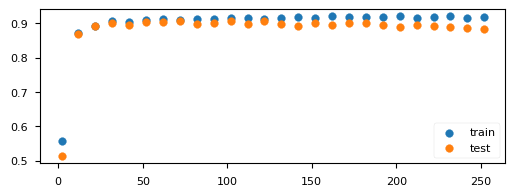

In [579]:
plt.figure(figsize=(6, 2))
plt.scatter(df_res['neurons'], df_res['accuracy_train'], label='train')
plt.scatter(df_res['neurons'], df_res['accuracy_test'], label='test')
plt.legend()
plt.show()
plt.close()

### Evaluate with moons

In [580]:
X_train, X_test, y_train, y_test = train_test_split(*get_moons(), test_size=.3)

In [581]:
model = ELMClassifier(neurons=256)
model.fit(X_train, y_train)
preds = (model.predict(X_test).reshape(-1, 1) > 0).reshape(-1) * 2 - 1
print(classification_report(
    y_true=y_test, y_pred=preds,
    zero_division=0,
))

              precision    recall  f1-score   support

          -1       0.97      0.96      0.97       295
           1       0.97      0.97      0.97       320

    accuracy                           0.97       615
   macro avg       0.97      0.97      0.97       615
weighted avg       0.97      0.97      0.97       615



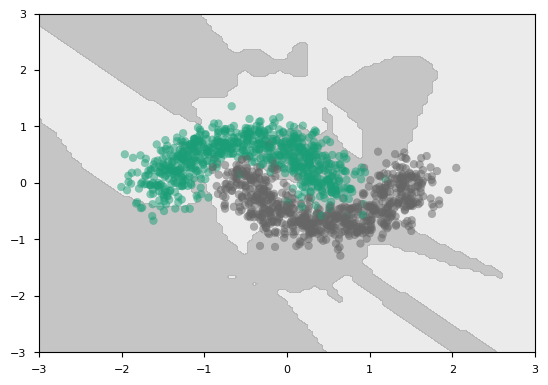

In [582]:
steps = 100
value = np.ceil(np.max([X_train.max(), np.abs(X_train.min())]))
grid = np.linspace(-1 * value, value, num = steps)
grid_data = np.array([[x0, x1] for x0 in grid for x1 in grid])

preds = (model.predict(grid_data).reshape(-1, 1) > 0).reshape(-1) * 2 - 1

plt.contourf(
    grid, grid,
    (preds * -1 > 0).reshape(steps, steps),
    levels=1, alpha=.3, cmap="binary"
)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, alpha=.5)

In [583]:
res = list()
for i in range(2, 256, 10):
    model = ELMClassifier(neurons=i)
    model.fit(X_train, y_train)

    res.append({
        'neurons': i,
        'accuracy_train': np.mean(
            (model.predict(X_train) > 0).reshape(-1)
            == (y_train > 0).reshape(-1)
        ),
        'accuracy_test': np.mean(
            (model.predict(X_test) > 0).reshape(-1)
            == (y_test > 0).reshape(-1)
        ),
    })
df_res = pd.json_normalize(res)

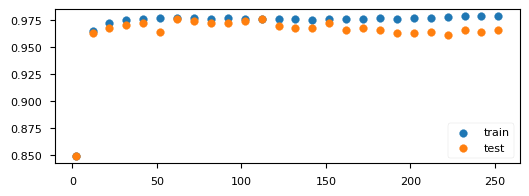

In [584]:
plt.figure(figsize=(6, 2))
plt.scatter(df_res['neurons'], df_res['accuracy_train'], label='train')
plt.scatter(df_res['neurons'], df_res['accuracy_test'], label='test')
plt.legend()
plt.show()
plt.close()

---